In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt

#from sktime.datasets import load_from_ucr_tsv_to_dataframe

from sktime.classification.dictionary_based import IndividualBOSS
from sktime.classification.interval_based import TimeSeriesForestClassifier
from sktime.classification.shapelet_based import ShapeletTransformClassifier


## Load Data ##

(36, 1) (36,) (175, 1) (175,)
                                                dim_0
0   0     -1.963009
1     -1.957825
2     -1.95614...
1   0     -1.774571
1     -1.774036
2     -1.77658...
2   0     -1.866021
1     -1.841991
2     -1.83502...
3   0     -2.073758
1     -2.073301
2     -2.04460...
4   0     -1.746255
1     -1.741263
2     -1.72274...
5   0     -1.982806
1     -1.978861
2     -1.93733...
6   0     -2.083023
1     -2.092058
2     -2.04946...
7   0     -1.633596
1     -1.643175
2     -1.61367...
8   0     -1.717013
1     -1.728059
2     -1.68330...
9   0     -2.245295
1     -2.223850
2     -2.17187...
10  0     -1.844180
1     -1.839913
2     -1.82574...
11  0     -1.833709
1     -1.827681
2     -1.77645...
12  0     -2.105590
1     -2.121538
2     -2.03591...
13  0     -1.900535
1     -1.882731
2     -1.86845...
14  0     -2.188812
1     -2.185519
2     -2.17646...
15  0     -2.164456
1     -2.178541
2     -2.06604...
16  0     -2.053743
1     -2.036852
2     -2.03303..

[Text(0.5, 1.0, 'Example time series'), Text(0.5, 0, 'Time')]

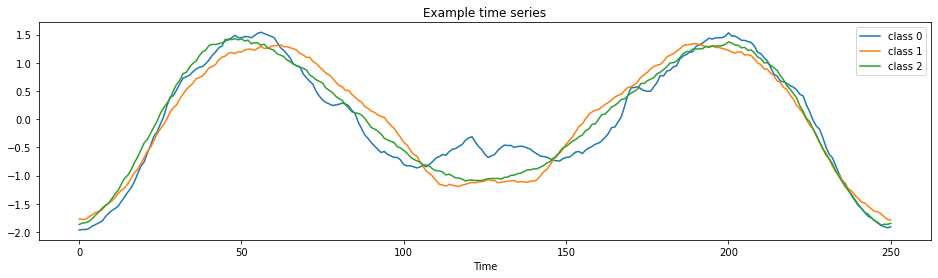

In [9]:
DATA_PATH = "./UCRArchive_2018"

X_train, y_train = load_from_ucr_tsv_to_dataframe(os.path.join(DATA_PATH, "ArrowHead/ArrowHead_TRAIN.tsv"))
X_test, y_test = load_from_ucr_tsv_to_dataframe(os.path.join(DATA_PATH, "ArrowHead/ArrowHead_TEST.tsv"))

# X_train: input: used to train the model
# y_train: output/labels for the training data to adjust the training
# X_test: input: tests the accuracy of the model after the training phase
# y_test: output/labels for the test data. used to test the accuracy between actual and predicted categories

print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

labels, counts = np.unique(y_train, return_counts=True)
print(labels, counts)

fig, ax = plt.subplots(1, figsize=plt.figaspect(0.25))
for label in labels:
    X_train.loc[y_train == label, "dim_0"].iloc[0].plot(ax=ax, label=f"class {label}")
plt.legend()
ax.set(title="Example time series", xlabel="Time")

## Set Parameters ##

In [3]:
dilation_size = 4

## Dilation Step ##

In [4]:
def dilation(X, d):
    first = X[:, :, 0::d]
    for i in range(1, d):
        second = X[:, :, i::d]
        first = np.concatenate((first, second), axis=2)
    return first

X_train_dilated = dilation(X_train, dilation_size)

## Classification ##

In [5]:
clf = IndividualBOSS()
clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)

In [1]:
# initialize the classifier object and fit the model on x_train and # y_train
clf = TimeSeriesForestClassifier()
clf.fit(X_train, y_train)

#make predictions and print the accuracy score for performance
y_pred = clf.predict(X_test)

NameError: name 'TimeSeriesForestClassifier' is not defined

## Evaluation/Benchmarking ##

In [3]:
from sklearn.metrics import accuracy_score

from sktime.benchmarking.data import UEADataset, make_datasets
from sktime.benchmarking.evaluation import Evaluator
from sktime.benchmarking.metrics import PairwiseMetric
from sktime.benchmarking.orchestration import Orchestrator
from sktime.benchmarking.results import HDDResults
from sktime.benchmarking.strategies import TSCStrategy
from sktime.benchmarking.tasks import TSCTask

from sktime.series_as_features.model_selection import PresplitFilesCV

In [4]:

DATA_PATH = "./UCRArchive_2018"
RESULTS_PATH = "results"

datasets = make_datasets(
    path=DATA_PATH, dataset_cls=UEADataset, names=["ArrowHead", "ItalyPowerDemand"]
)

tasks = [TSCTask(target="target") for _ in range(len(datasets))]

strategies = [
    TSCStrategy(IndividualBOSS(n_estimators=10), name="boss"),
    TSCStrategy(TimeSeriesForestClassifier(n_estimators=10), name="rise"),
    TSCStrategy(ShapeletTransformClassifier(n_estimators=10), name="st"),
]

results = HDDResults(path=RESULTS_PATH)

# run orchestrator
orchestrator = Orchestrator(
    datasets=datasets,
    tasks=tasks,
    strategies=strategies,
    cv=PresplitFilesCV(),
    results=results,
)
orchestrator.fit_predict(save_fitted_strategies=False, overwrite_predictions=True)

evaluator = Evaluator(results)
metric = PairwiseMetric(func=accuracy_score, name="accuracy")
metrics_by_strategy = evaluator.evaluate(metric=metric)
metrics_by_strategy.head()

# 1. accuracy
# accuracy_score(y_test, y_pred)
# 2. runtime

# 3. memory

ValueError: No dataset found at path: ./UCRArchive_2018/ArrowHead/ArrowHead_TRAIN.ts